In [1]:
# Diving deeper into the BBC News archive
# tokenization process + create a classifier using specialized layers for text data
# such as Embedding and GlobalAveragePooling1D

import io
import csv
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

In [2]:
with open("bbc-text.csv", 'r') as csvfile:
    print(f"First line (header): {csvfile.readline()}")
    print(f"Each data point: {csvfile.readline()}")

First line (header): category,text

Each data point: tech,tv future in the hands of viewers with home theatre systems  plasma high-definition tvs  and digital video recorders moving into the living room  the way people watch tv will be radically different in five years  time.  that is according to an expert panel which gathered at the annual consumer electronics show in las vegas to discuss how these new technologies will impact one of our favourite pastimes. with the us leading the trend  programmes and other content will be delivered to viewers via home networks  through cable  satellite  telecoms companies  and broadband service providers to front rooms and portable devices.  one of the most talked-about technologies of ces has been digital and personal video recorders (dvr and pvr). these set-top boxes  like the us s tivo and the uk s sky+ system  allow people to record  store  play  pause and forward wind tv programmes when they want.  essentially  the technology allows for much m

In [3]:
# Define useful global variables

NUM_WORDS = 1000
EMBEDDING_DIM = 16
MAXLEN = 120
PADDING = 'post'
OOV_TOKEN = "<OOV>"
TRAINING_SPLIT = 0.8

In [4]:
# Load and pre-processing the data

def remove_stopwords(sentence):
    """
    Removes a lists of stopwords
    Args: sentence (string): sentence to remove the stopwords from
    Returns: sentence (string): lowercase sentence without the stopwords
    """
    
    # Lists of stopwords
    stopwords = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]
    
    # Sentence converted to lowercase-only
    sentence = sentence.lower()
    
    words = sentence.split()
    no_words = [w for w in words if w not in stopwords]
    sentence = " ".join(no_words)
    
    return sentence


def parse_data_from_file(filename):
    """
    Extracts sentences and labels from a CSV file
    Args: filename (string): path to the CSV file
    Returns: sentence, labels (list of string, list of string): tuple containing lists of sentences
           and labels
    """
    
    sentences = []
    labels = []
    with open(filename, 'r') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        next(reader)
        for row in reader:
            labels.append(row[0])
            sentence = row[1]
            sentence = remove_stopwords(sentence)
            sentences.append(sentence)
            
    return sentences, labels

In [5]:
# Test the functions

sentences, labels = parse_data_from_file("bbc-text.csv")

print(f"There are {len(sentences)} sentences in the dataset")
print(f"The first sentence has {len(sentences[0].split())} words (after removing stopwords)")
print(f"There are {len(labels)} labels in the dataset")
print(f"The first 5 labels are {labels[:5]}")

There are 2225 sentences in the dataset
The first sentence has 436 words (after removing stopwords)
There are 2225 labels in the dataset
The first 5 labels are ['tech', 'business', 'sport', 'sport', 'entertainment']


In [6]:
# Training - Validation split

def train_val_split(setences, labels, training_split):
    """
    Splits the dataset into training and validation sets
    Args:
        sentences (list of string): lower-cased sentences without stopwords
        labels (list of string): list of labels
        training_split (float): proportion of the dataset to be in training set
    Returns:
        training_sentences, validation_sentences, training_labels, validation_labels
    """
    
    # Compute the number of sentences that will be used for training (integer)
    train_size = int(len(sentences)*training_split)
    
    # Split the sentences and labels into train/validation splits
    train_sentences = sentences[:train_size]
    train_labels = labels[:train_size]
    
    validation_sentences = sentences[train_size:]
    validation_labels = labels[train_size:]
    
    return train_sentences, validation_sentences, train_labels, validation_labels

In [7]:
# Test the function

train_sentences, val_sentences, train_labels, val_labels = train_val_split(sentences, labels, TRAINING_SPLIT)

print(f"There are {len(train_sentences)} sentences for training")
print(f"There are {len(train_labels)} labels for training")
print(f"There are {len(val_sentences)} sentences for testing")
print(f"There are {len(val_labels)} labels for testing")

There are 1780 sentences for training
There are 1780 labels for training
There are 445 sentences for testing
There are 445 labels for testing


In [8]:
# Tokenization - Sequences and padding

def fit_tokenizer(train_sentences, num_words, oov_token):
    """
    Instantiates the Tokenizer class on the training sentences
    Args:
        train_sentences (list of string): lower-cased sentences without stopwords for training
        num_words (int): number of words to keep when tokenizing
        oov_token (string): Out-Of_Vocabulary token
    Returns:
        tokenizer (object): an instance of the Tokenizer class containing the word-index dict
    """
    
    # Instantiate the Tokenizer class
    tokenizer = Tokenizer(num_words=num_words, oov_token=oov_token)
    
    # Fit the tokenizer to the training sentences
    tokenizer.fit_on_texts(train_sentences)
    
    return tokenizer

In [9]:
# Test the function

tokenizer = fit_tokenizer(train_sentences, NUM_WORDS, OOV_TOKEN)
word_index = tokenizer.word_index

print(f"Vocabulary contains {len(word_index)} words")
print("<OOV> token included in vocabulary" if "<OOV>" in word_index else "<OOV> NOT in vocab")

Vocabulary contains 27285 words
<OOV> token included in vocabulary


In [10]:
# Convert each text data point into its padded sequence representation

def seq_and_pad(sentences, tokenizer, padding, maxlen):
    """
    Generates an array of token sequences and pads then to the same lenght
    Args:
        sentences (list of string): list of sentences to tokenize and pad
        tokenizer (object): Tokenizer instance containing the word-index dictionary
        padding (string): type of padding to use
        maxlen (int): maximum length of the token sequence
    Returns:
        padded_sequences (array of int): tokenized sentences padded to the same length
    """
    
    # Convert sentences to sequences
    sequences = tokenizer.texts_to_sequences(sentences)
    
    # Pad the sequences with padding and maxlen
    padded_sequences = pad_sequences(sequences, maxlen=maxlen, padding=padding)
    
    return padded_sequences

In [11]:
# Test the function
train_padded_seq = seq_and_pad(train_sentences, tokenizer, PADDING, MAXLEN)
val_padded_seq = seq_and_pad(val_sentences, tokenizer, PADDING, MAXLEN)

print(f"Padded training sequences have shape: {train_padded_seq.shape}")
print(f"Padded validation sequences have shape: {val_padded_seq.shape}")

Padded training sequences have shape: (1780, 120)
Padded validation sequences have shape: (445, 120)


In [16]:
# Tokenize the labels

# In the labels should never be a OOV label

# pad_sequences uses numpy array. But for labels this is not needed. Dont need to pad labels

# The argument split_labels refers to the labels of a particular plit (train or validation)
# the function should work independently of the split being used

# Using keras' Tokenizer yields values that start at 1 not zero
# substract 1 from every value of the labels that the function returns np.array - 1

def tokenize_labels(all_labels, split_labels):
    """
    Tokenizes the labels
    Args:
        all_labels (list of string): labels to generate the word-index from
        split_labels (list of string): labels to tokenize
    Returns:
        label_seq_np (array of int): tokenized labels
    """
    
    # Instantiate the Tokenizer
    label_tokenizer = Tokenizer()
    
    # Fit the tokenizer on all the labels
    label_tokenizer.fit_on_texts(all_labels)
    
    # Convert labels to sequences
    label_seq = label_tokenizer.texts_to_sequences(split_labels)#(all_labels)
    
    # Convert sequences to numpy array. Substract 1 from every entry in the array
    label_seq_np = np.array(label_seq) - 1
    
    return label_seq_np

In [17]:
# Test function
train_label_seq = tokenize_labels(labels, train_labels)
val_label_seq = tokenize_labels(labels, val_labels)

print(f"First 5 labels of the training set:\n{train_label_seq[:5]}")
print(f"first 5 labels of the validation set:\n{val_label_seq[:5]}")
print(f"Tokenized labels of the training set have shape:{train_label_seq.shape}")
print(f"Tokenized labels of the validation set have shape:{val_label_seq.shape}")

First 5 labels of the training set:
[[3]
 [1]
 [0]
 [0]
 [4]]
first 5 labels of the validation set:
[[4]
 [3]
 [2]
 [0]
 [0]]
Tokenized labels of the training set have shape:(1780, 1)
Tokenized labels of the validation set have shape:(445, 1)


In [29]:
d = dict()
for i in labels:
    d[i] = d.get(i,0)+1
print(f"These are all the classes {len(d)} : \n{d}")

These are all the classes 5 : 
{'tech': 401, 'business': 510, 'sport': 511, 'entertainment': 386, 'politics': 417}


In [20]:
# Model for text classification

# The three parameters to be passed to an Embedding layer (first layer)

# Last layer is a Dense layer with 5 units (5 categories) with a softmax activation

# Layers: Embedding, GlobalAveragePooling1D and Dense layers ~30epochs training 95% val 90% accuracy

def create_model(num_words, embedding_dim, maxlen):
    """
    Creates a text classifier model
    Args:
        num_words (int): size of the vocabulary for the Embedding layer input
        embedding_dim (int): dimensionality of the Embedding layer output
        maxlen (int): length of the input sequences
    Returns:
        model (tf.keras Model): the text classifier model
    """
    
    tf.random.set_seed(123)
    
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(num_words, embedding_dim, input_length=maxlen),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(24, activation='relu'),
        tf.keras.layers.Dense(5, activation='softmax')
    ])
    
    model.compile(loss='sparse_categorical_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy'])
    
    return model

In [21]:
model = create_model(NUM_WORDS, EMBEDDING_DIM, MAXLEN)

history = model.fit(train_padded_seq, train_label_seq, epochs=30,
                   validation_data=(val_padded_seq, val_label_seq))

Epoch 1/30
56/56 [==============================] - 1s 3ms/step - loss: 1.5988 - accuracy: 0.2826 - val_loss: 1.5817 - val_accuracy: 0.4539
Epoch 2/30
56/56 [==============================] - 0s 2ms/step - loss: 1.5505 - accuracy: 0.4393 - val_loss: 1.5072 - val_accuracy: 0.4449
Epoch 3/30
56/56 [==============================] - 0s 2ms/step - loss: 1.4295 - accuracy: 0.5129 - val_loss: 1.3490 - val_accuracy: 0.5461
Epoch 4/30
56/56 [==============================] - 0s 2ms/step - loss: 1.2200 - accuracy: 0.6320 - val_loss: 1.1292 - val_accuracy: 0.6899
Epoch 5/30
56/56 [==============================] - 0s 2ms/step - loss: 0.9706 - accuracy: 0.7820 - val_loss: 0.9012 - val_accuracy: 0.7798
Epoch 6/30
56/56 [==============================] - 0s 2ms/step - loss: 0.7353 - accuracy: 0.8742 - val_loss: 0.7046 - val_accuracy: 0.8697
Epoch 7/30
56/56 [==============================] - 0s 2ms/step - loss: 0.5476 - accuracy: 0.9230 - val_loss: 0.5573 - val_accuracy: 0.8787
Epoch 8/30
56/56 [==

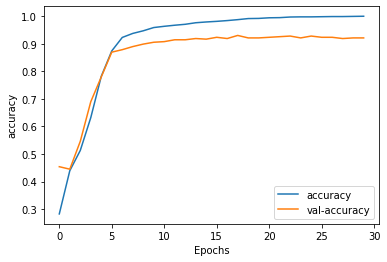

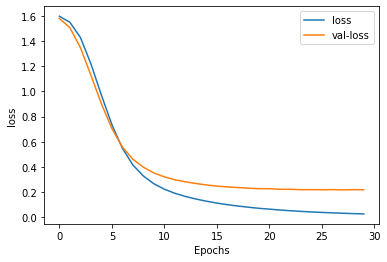

In [23]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f"val_{metric}"])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f"val-{metric}"])
    plt.show()
    
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [24]:
# Visualizing 3D vectors

# Reverse word index
reverse_word_index = dict([value, key] for (key, value) in word_index.items())

# Save the embedding layer
e = model.layers[0]

# Save the weights of the embedding layer
weights = e.get_weights()[0]
print(f"Weights of embedding layers shape: {weights.shape}")

Weights of embedding layers shape: (1000, 16)


In [25]:
# Generate files for embedding visualization
out_v = io.open('vecs_BBC.tsv','w',encoding='utf-8')
out_m = io.open('meta_BBC.tsv','w',encoding='utf-8')

for word_num in range(1, NUM_WORDS):
    word = reverse_word_index[word_num]
    embeddings = weights[word_num]
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")

out_v.close()
out_m.close()

In [ ]:
# https://projector.tensorflow.org/